### Import modules

In [2]:
import networkx as nx
from graph_bandit_helper_tools import return_graph,draw_graph
from core import train_agent

import numpy as np
from functools import partial
from time import time

import pickle as pkl

from matplotlib import pyplot as plt
import seaborn as sns

import random

%load_ext autoreload
%autoreload 2

SEED = 181731

In [11]:
from agents import get_ucb,UCRL2_ucb

from known_rewards_helper_functions import offline_SP_planning

def UCB_Doubling_agent(env,delta = 0.01, UCB = 'G-UCB', doubling = 'G-UCB'):
    '''
        The general agent that morphs between our algorithm and the UCRL2 algorithm
    '''
    # print(UCB,offline_planning,doubling)
    
    # Possible Difference 1: The definition of UCB.
    if UCB == 'G-UCB':
        ucb = get_ucb(env)
    elif UCB == 'UCRL2':
        ucb = UCRL2_ucb(env,delta = delta)
    else:
        assert(False)
    
    # Compute optimal policy. We use the truly optimal SP planning.
    policy,_,_ = offline_SP_planning(env.G,ucb)

    # Possible Difference 2: The doubling scheme
    if doubling == 'G-UCB':        
        # Travel to the node with the highest UCB
        while ucb[env.state] < np.max(ucb):
            next_s = policy[env.state]
            env.step(next_s)

        target_count = 0+env.nodes[env.state]['n_visits']
        # Keep sampling the best UCB node until its number of samples doubles
        for _ in range(target_count):
            env.step(env.state)
            
    elif doubling == 'UCRL2':
        prev_visits = {s:env.nodes[s]['n_visits'] for s in env.G}
        visits_this_episode = {s:0 for s in env.G}

        # Keep executing the policy until the doubling terminal condition specified in Jacksh(2008) is meet.
        while visits_this_episode[env.state]< np.max([1,prev_visits[env.state]]):
            visits_this_episode[env.state]+=1
            next_s = policy[env.state]
            env.step(next_s)
    else:
        assert(False)

In [9]:
def plotRegrets(line_regret, titles=None, save_fig=None):
    """
    agents: A list of dictionaries. Each dictionary contains the configuration of a run and the corresponding regret.
    """
    sns.set()
    
    for name,regret in line_regret.items():
        regret = np.cumsum(regret, axis=1)
        regret = np.mean(regret, axis=0)
        sd = np.std(regret,axis=0)

        
        # plt.plot([i for i in range(1,len(regret)+1)],regret, label=label,\
                # linewidth=3)
            
        plot_every = int(len(regret)/7)
         
        plt.errorbar(range(1,len(regret)+1), regret ,sd,errorevery=plot_every,\
                     label=name,linewidth=3,\
                    capsize=5,elinewidth=3)
            
    if titles is not None:    
        plt.title(titles[0])
            
    plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.45), fontsize=16)
    plt.xlabel('$t$', fontsize=20)
    plt.ylabel('Expected regret', fontsize=20)
    plt.tick_params(labelsize=20)
    plt.style.use('seaborn-dark-palette')
    plt.show()

### Define parameters

In [10]:
n_samples = 20

init_node = 0

# The effect of different components on the Algorithm

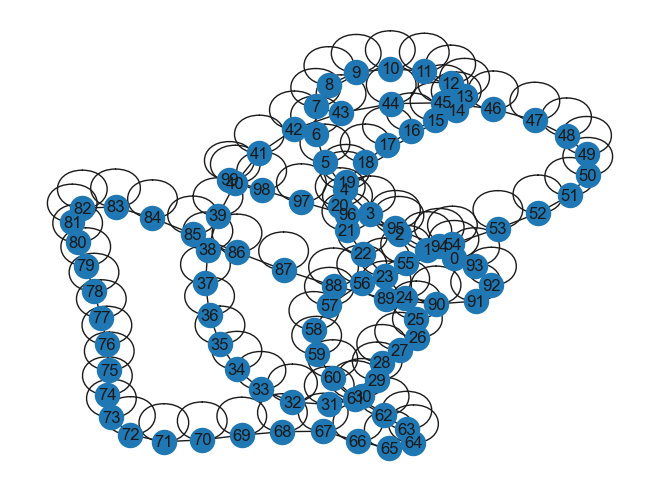

Run time for G-UCB-G-UCB: 1.450739860534668
Run time for G-UCB-UCRL2: 1.420924186706543
Run time for UCRL2-G-UCB: 1.3818318843841553
Run time for UCRL2-UCRL2: 1.7608990669250488


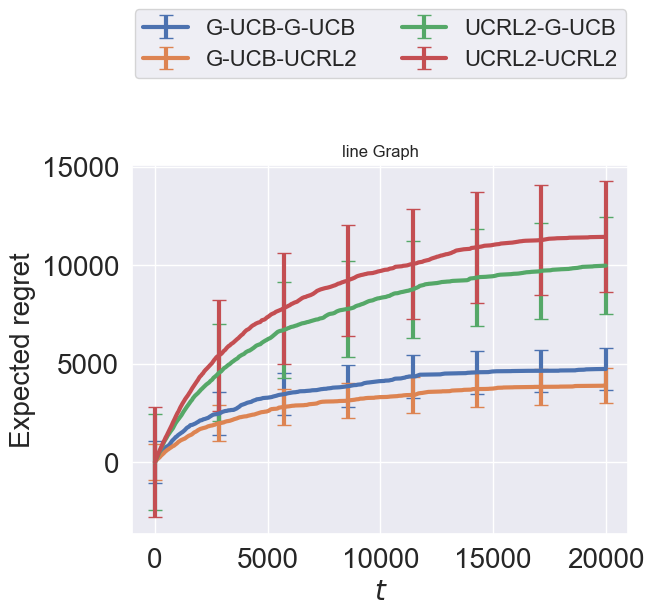

Total run time: 6.160392999649048


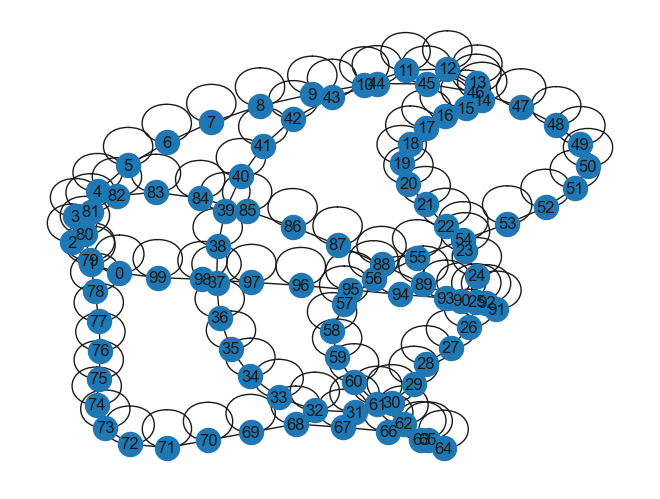

Run time for G-UCB-G-UCB: 1.1049792766571045
Run time for G-UCB-UCRL2: 1.5456531047821045
Run time for UCRL2-G-UCB: 1.5314249992370605
Run time for UCRL2-UCRL2: 1.948124885559082


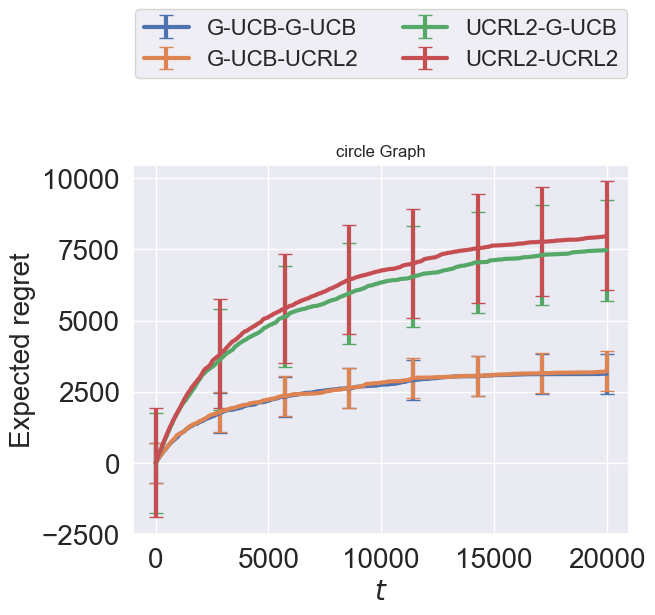

Total run time: 6.245666980743408


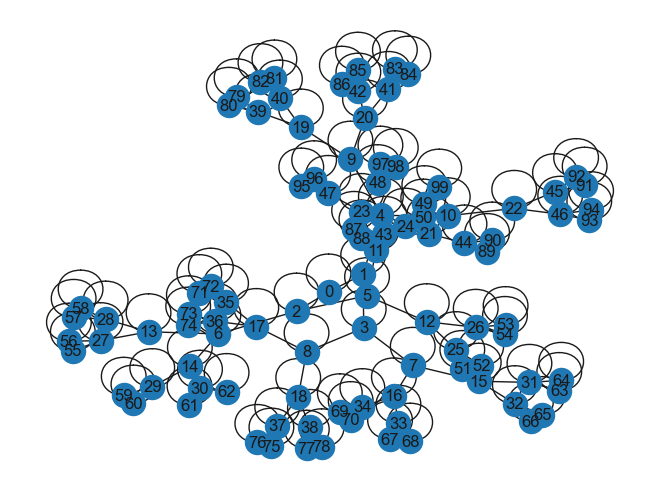

Run time for G-UCB-G-UCB: 0.6242351531982422
Run time for G-UCB-UCRL2: 0.9982290267944336
Run time for UCRL2-G-UCB: 0.800482988357544
Run time for UCRL2-UCRL2: 1.2719638347625732


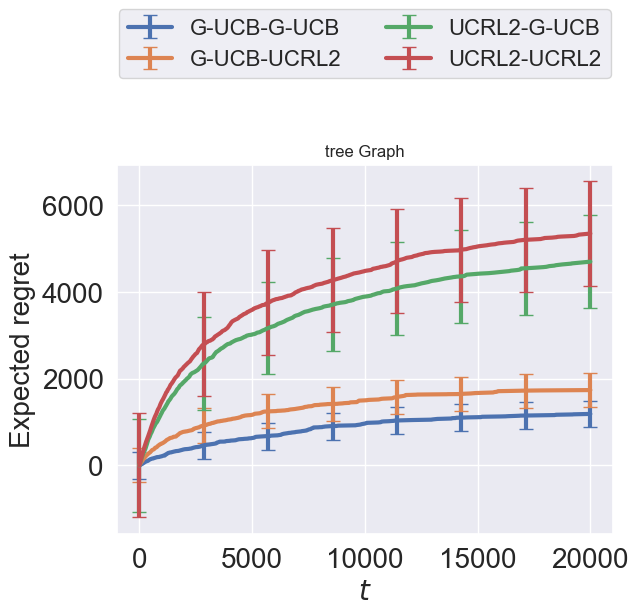

Total run time: 3.8077750205993652


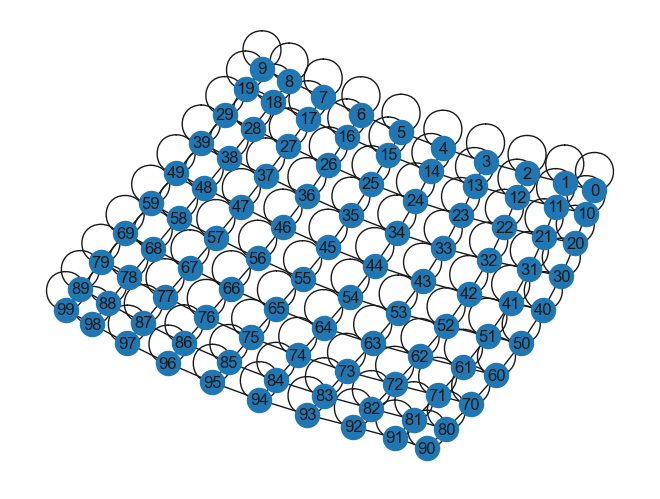

Run time for G-UCB-G-UCB: 0.8045330047607422
Run time for G-UCB-UCRL2: 1.2815489768981934
Run time for UCRL2-G-UCB: 1.0266399383544922
Run time for UCRL2-UCRL2: 1.545447826385498


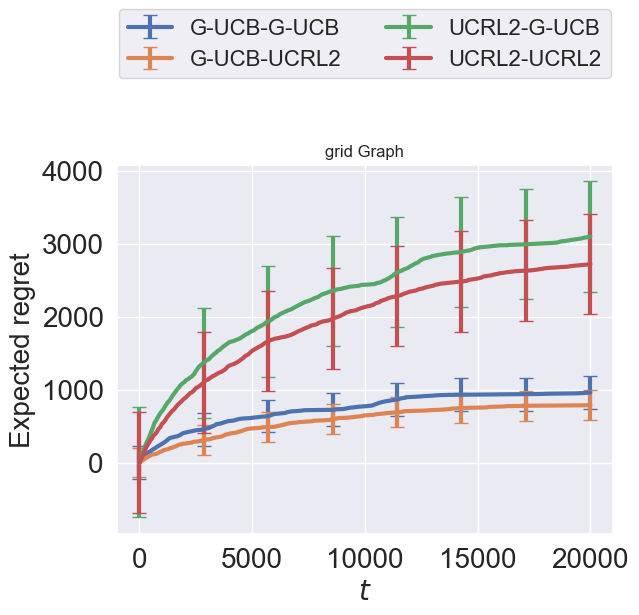

Total run time: 4.7722790241241455


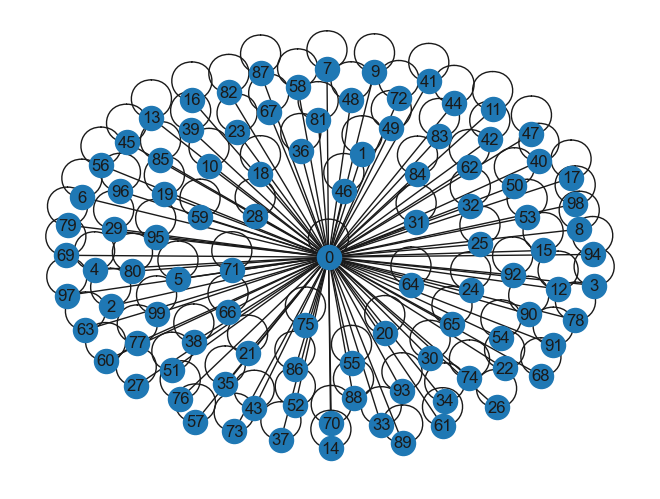

Run time for G-UCB-G-UCB: 0.6299870014190674
Run time for G-UCB-UCRL2: 1.1203498840332031
Run time for UCRL2-G-UCB: 0.8513109683990479
Run time for UCRL2-UCRL2: 1.3764989376068115


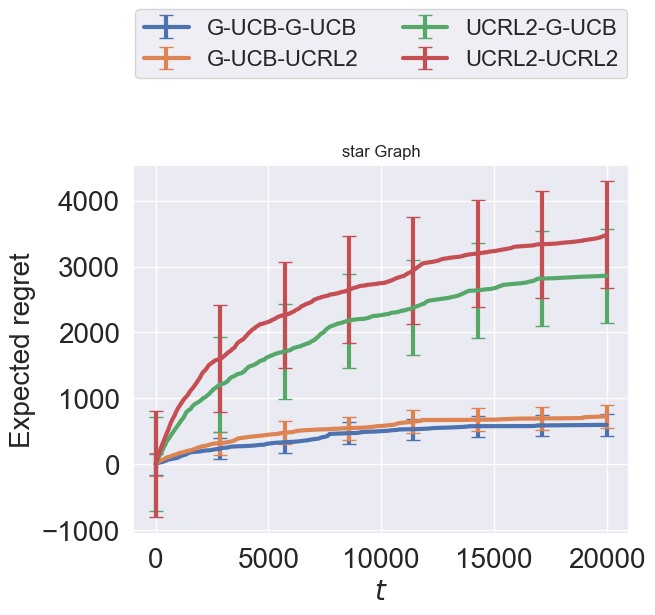

Total run time: 4.095847845077515


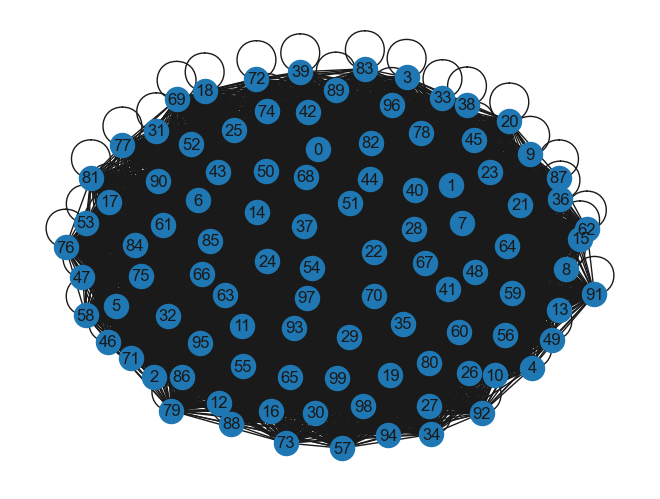

Run time for G-UCB-G-UCB: 6.472787141799927
Run time for G-UCB-UCRL2: 7.524993181228638
Run time for UCRL2-G-UCB: 12.510835886001587
Run time for UCRL2-UCRL2: 14.805922985076904


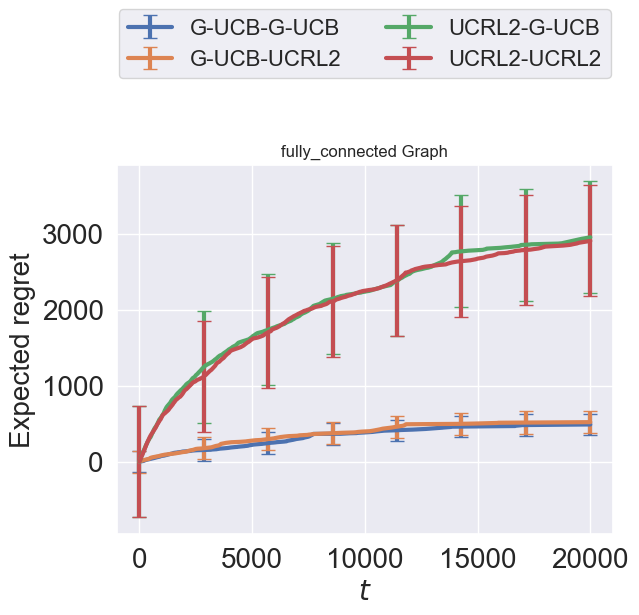

Total run time: 41.4336519241333


In [13]:
graph_types = ['line','circle','tree','grid','star','fully_connected']

T = 20000
n_nodes = 100

algs = ['G-UCB','UCRL2']
agents = []
for ucb_alg in algs:
        for doubling_alg in algs:
                agents.append(
                    {'UCB':ucb_alg,
                     'Doubling':doubling_alg,
                    } 
                )

for profile in agents:
    profile['agent']= partial(UCB_Doubling_agent,UCB=profile['UCB'], doubling=profile['Doubling'])

            
for graph in graph_types:
    
    np.random.seed(SEED)
    random.seed(SEED)
    G = return_graph(graph, n_nodes)
    draw_graph(G)

    np.random.seed(SEED)
    random.seed(SEED)
    means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))

    t0 = time()
    line_regrets = {}
    for alg_profile in agents:
        t = time()
        
        name = '{}-{}'.format(alg_profile['UCB'],alg_profile['Doubling'])
        
        line_regrets[name] = train_agent(n_samples,T,G,means, init_node,alg_profile['agent'],parallelized=True)
        
        print('Run time for {}:'.format(name),time()-t)

    with open('Data/{}_vsUCRL2.pkl'.format(graph), 'wb') as file:
        pkl.dump(line_regrets,file)
        
    plt.figure(dpi=100)
    plotRegrets(line_regrets,titles=['{} Graph'.format(graph)])
    

    print('Total run time:', time()-t0)
    
